In [2]:
import zipline as zp
from zipline import TradingAlgorithm
from zipline.api import order_target, record, symbol, history, add_history 

import pytz
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

#from pandas_datareader import data, wb
import pandas as pd 
import statsmodels.api as sm

from scipy import optimize
from scipy.optimize import minimize
from statsmodels.tsa.ar_model import AR

%matplotlib inline

### 1.  Model

#### Stationarity

Stationarity of a financial time series data is the base of pair trading strategy. Though there are many variations of pair trading, they all rely on some form of stationarity. 

There are varying degree of abstarctions in defining stationarity. We defer the precise definition and consider its useful properties in the context of examples. Two important properties of statinary time series that support pair trading is that they have a constant mean and deviation(volatility), at least for a given time period.

Consider a (contrived) example of stationary time series:

(-1.5, 1.5)

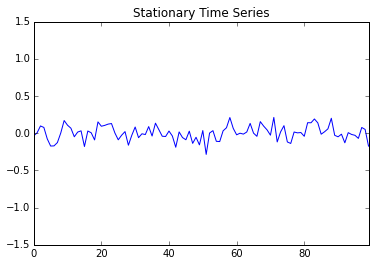

In [63]:

ts = pd.Series(np.random.normal(0,0.1,100)) # make ts pandas series format then plot
ts.plot()

plt.title('Stationary Time Series')
plt.ylim([-1.5,1.5])

Realistic financial data would look more like below:

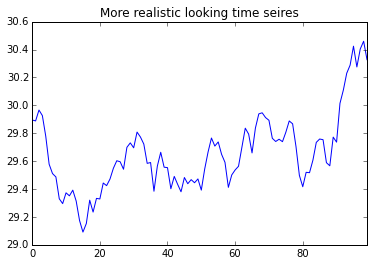

In [29]:
mu = 30.0
more_real_ts = pd.Series(np.cumsum(ts)) + mu
more_real_ts.plot()
plt.title("More realistic looking time seires")

If we can extract stationary part of this time series data, we can trigger buy or sell order when data goes outside "deviation band" around its mean. 

(-1.0, 1.0)

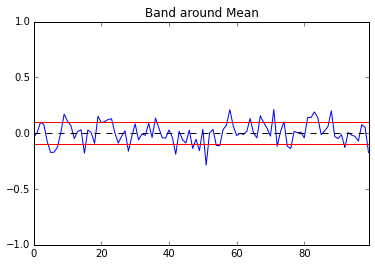

In [65]:
# A band around stationary time series
ts.plot()
plt.axhline(ts.mean(), color='black', linestyle='--')
plt.axhline(ts.mean()+ts.std(), color='red')
plt.axhline(ts.mean()-ts.std(), color='red')
plt.title('Band around Mean')# thickness of the band to be decided
plt.ylim([-1.0,1.0])

#### Regression

A common pair trading strategy start with choosing a pair of equities, say $x(t)$ and $y(t)$, that we consider "related".  We can formalize this intuitive notion of "being related" by using regression. For example, we may observe that a form of difference between $y(t)$ and $x(t)$ is stationary: it fluctuates in a predictable way. In simple linear regression model, we can choose some $\alpha$ so that $y(t) - \alpha x(t)$ is stationary. 

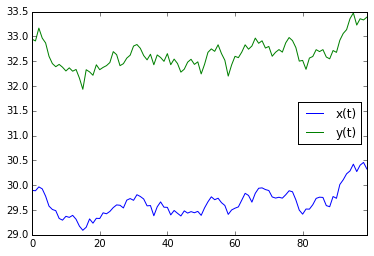

In [37]:
x = more_real_ts
x.name = 'x(t)'

noise = np.random.normal(0,0.08, 100)
y = x + noise + 3.0
y.name='y(t)'
pd.concat([x,y], axis=1).plot()

Surely, this is a contrived example as we generated $y(t)$ from $x(t)$, whence we know their exact relation. In practice, our first challenge is to find related data, then form a regression model for them.  

Our choice of a pair does not have to come from two different equities.  The pair can come from a single source. For example, we can consider regression relation between $x(t)$ and its own history $x(t-p)$ (or moving averages of different periods). This type of regression is called AutoRegression, AR in short. Autoregression quantifies our intuition of "current data is influtenced by its history."


There are several statistical tests to investigate 'relatedness' of data.  

AE
AAPL
0.0573955431919


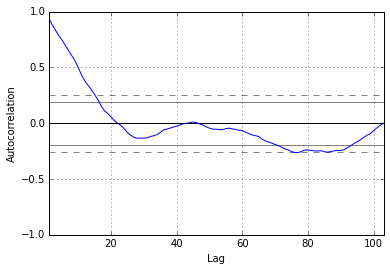

In [59]:
start = datetime(2015, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2015, 6, 1, 0, 0, 0, 0, pytz.utc)
stocks = zp.utils.factory.load_from_yahoo(stocks=['AE', 'AAPL'], indexes={},
                                        start=start, end=end, adjusted=True)

ex_x = stocks['AE'] 
ex_y = stocks['AAPL']

# See how two stocks are correlated
print ex_x.corr(ex_y)

# AutoCorrelationFunction

#from statsmodels.graphics import tsaplots
#tsaplots.plot_acf(x)

pd.tools.plotting.autocorrelation_plot(ex_y)

To be continued: We will expand into more complex and realistic models